In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats
from sklearn.covariance import EllipticEnvelope

from numba import jit
from functools import partial

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from statsmodels.regression.quantile_regression import QuantReg
import statsmodels.api as sm

Duplicate key in file WindowsPath('d:/source/Anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 258 ('font.family:  Microsoft JhengHei')


In [71]:
TXF_df = pd.read_parquet("datas/SJ_下載09月的TXF逐筆成交明細.pqt")
ZEF_df = pd.read_parquet("datas/SJ_下載09月的ZEF逐筆成交明細.pqt")

In [ ]:
TXF_df.ts = pd.to_datetime(TXF_df.ts)
ZEF_df.ts = pd.to_datetime(ZEF_df.ts)

TXF_df = TXF_df.set_index("ts")
ZEF_df = ZEF_df.set_index("ts")
# 然後才能對他們resample
TXF_df_sec = TXF_df.resample("1s").last()
ZEF_df_sec = ZEF_df.resample("1s").last()
TXF_df_sec = TXF_df_sec.dropna().reset_index()
ZEF_df_sec = ZEF_df_sec.dropna().reset_index()

In [ ]:
# 這兩行解決時間戳重複的問題
# TXF_df = TXF_df.groupby(TXF_df.index).mean()
# ZEF_df = ZEF_df.groupby(ZEF_df.index).mean()
# XIF_df = XIF_df.groupby(XIF_df.index).mean()
# FXF_df = FXF_df.groupby(FXF_df.index).mean()


In [73]:
ZEF_df_sec.head()

,close,volume,bid_price,bid_volume,ask_price,ask_volume,tick_type
ts,,,,,,,
2024-08-30 15:00:00,1190.45,1.0,0.0,0.0,0.0,0.0,1.0
2024-08-30 15:00:01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-08-30 15:00:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-08-30 15:00:03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-08-30 15:00:04,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
# 轉換 ts 欄位成 datetime 格式
TXF_df_sec["ts"] = pd.to_datetime(TXF_df_sec["ts"])
ZEF_df_sec["ts"] = pd.to_datetime(ZEF_df_sec["ts"])

# 使用 merge_asof 進行時間戳配對
merged_df = pd.merge_asof(
    ZEF_df_sec[["ts", "close"]],
    TXF_df_sec[["ts", "close"]],
    on="ts",
    suffixes=("_zef", "_txf"),
    direction="backward",
)

# 最後只保留需要的欄位
ZEF_TXF_sec = merged_df[["ts", "close_txf", "close_zef"]]

ZEF_TXF_sec

,ts,close_txf,close_zef
0,2024-08-30 15:00:00,22325.0,1190.45
1,2024-08-30 15:01:04,22312.0,1191.10
2,2024-08-30 15:05:03,22308.0,1191.45
3,2024-08-30 15:05:08,22306.0,1191.35
4,2024-08-30 15:05:54,22317.0,1191.90
...,...,...,...
23312,2024-09-27 13:44:06,22900.0,1227.60
23313,2024-09-27 13:44:08,22899.0,1228.50
23314,2024-09-27 13:44:10,22897.0,1228.50
23315,2024-09-27 13:44:24,22895.0,1227.60


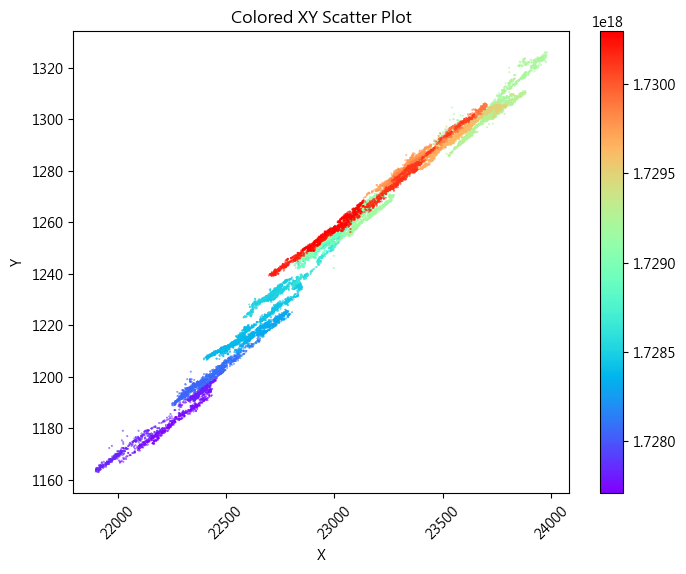

In [22]:
import matplotlib.dates as mdates

# 繪製散點圖
plt.figure(figsize=(8, 6))
plt.scatter(
    ZEF_TXF_sec["close_txf"],
    ZEF_TXF_sec["close_zef"],
    c=ZEF_TXF_sec.ts,
    cmap="rainbow",
    s=0.1,
)

# 設定x軸為日期格式
ax = plt.gca()
# ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=45)

# 添加標題和軸標籤
plt.title("Colored XY Scatter Plot")
plt.xlabel("X")
plt.ylabel("Y")

# 顯示圖形
plt.colorbar()
plt.show()

In [77]:
df = ZEF_TXF_sec.copy()
# 假設 `df` 是您的資料
# 建立 datetime index
df["ts"] = pd.to_datetime(df["ts"])  # 確保 datetime 欄位是 datetime 格式
df.set_index("ts", inplace=True)

# 每天的 15:00 到 15:10 的最後價格作為基準
# 首先將資料根據日期分組
df["date"] = df.index.date  # 提取日期
base_prices = (
    df.between_time("15:00", "15:10").groupby("date").last()
)  # 每天 15:10 的最後價格

# base_prices 包含每天的基準價格
df["txf_base"] = df["date"].map(base_prices["close_txf"])  # 將基準價格映射到 df 中
df["zef_base"] = df["date"].map(base_prices["close_zef"])

# 計算漲跌百分比
df["txf_percent"] = ((df["close_txf"] - df["txf_base"]) / df["txf_base"])
df["zef_percent"] = ((df["close_zef"] - df["zef_base"]) / df["zef_base"])

# 清理不再需要的欄位
# df.drop(columns=["txf_base", "zef_base", "date"], inplace=True)

# print(df[["close_txf", "txf_percent", "close_zef", "zef_percent"]])
df.head()

,close_txf,close_zef,date,txf_base,zef_base,txf_percent,zef_percent
ts,,,,,,,
2024-08-30 15:00:00,22325.0,1190.45,2024-08-30,22299.0,1191.1,0.001166,-0.000546
2024-08-30 15:01:04,22312.0,1191.10,2024-08-30,22299.0,1191.1,0.000583,0.000000
2024-08-30 15:05:03,22308.0,1191.45,2024-08-30,22299.0,1191.1,0.000404,0.000294
2024-08-30 15:05:08,22306.0,1191.35,2024-08-30,22299.0,1191.1,0.000314,0.000210
2024-08-30 15:05:54,22317.0,1191.90,2024-08-30,22299.0,1191.1,0.000807,0.000672


In [78]:
# 假設 df 已有 datetime 欄位，並且該欄位是 datetime 格式
# df["datetime"] = pd.to_datetime(df["datetime"])  # 確保 datetime 欄位是 datetime 格式
# df.set_index("datetime", inplace=True)

# 建立條件來篩選時間範圍
filtered_df = df.between_time("15:00", "23:59")  # 首先保留當天15:00至當日23:59的資料
next_day_data = df.between_time("00:00", "04:00")  # 保留隔日00:00至04:00的資料

# 將兩個範圍的資料合併
filtered_df = pd.concat([filtered_df, next_day_data]).dropna()

filtered_df

,close_txf,close_zef,date,txf_base,zef_base,txf_percent,zef_percent
ts,,,,,,,
2024-08-30 15:00:00,22325.0,1190.45,2024-08-30,22299.0,1191.1,0.001166,-0.000546
2024-08-30 15:01:04,22312.0,1191.10,2024-08-30,22299.0,1191.1,0.000583,0.000000
2024-08-30 15:05:03,22308.0,1191.45,2024-08-30,22299.0,1191.1,0.000404,0.000294
2024-08-30 15:05:08,22306.0,1191.35,2024-08-30,22299.0,1191.1,0.000314,0.000210
2024-08-30 15:05:54,22317.0,1191.90,2024-08-30,22299.0,1191.1,0.000807,0.000672
...,...,...,...,...,...,...,...
2024-09-26 03:38:30,22898.0,1232.50,2024-09-26,23044.0,1241.9,-0.006336,-0.007569
2024-09-26 03:39:16,22894.0,1232.20,2024-09-26,23044.0,1241.9,-0.006509,-0.007811
2024-09-26 03:47:33,22913.0,1232.95,2024-09-26,23044.0,1241.9,-0.005685,-0.007207


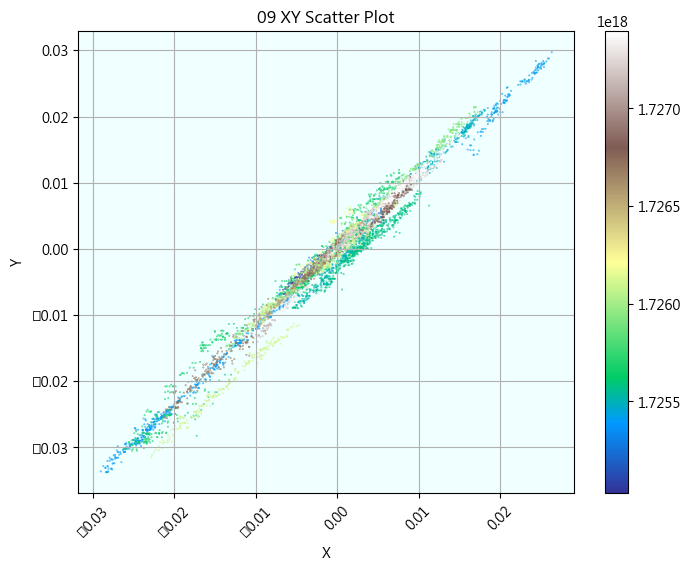

In [80]:
%matplotlib inline
TXF_ZEF自減價格關係_df = filtered_df.copy()
# 繪製散點圖
plt.figure(figsize=(8, 6))
plt.scatter(
    TXF_ZEF自減價格關係_df["txf_percent"],
    TXF_ZEF自減價格關係_df["zef_percent"],
    c=TXF_ZEF自減價格關係_df.index,
    cmap="terrain",  # "Wistia",  # "CMRmap",  # "Greys",
    s=0.1,
)

# 設定x軸為日期格式
ax = plt.gca()
ax.set_facecolor("azure")
# ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=45)

# 添加標題和軸標籤
plt.title("09 XY Scatter Plot")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
# 顯示圖形
plt.colorbar()
plt.show()

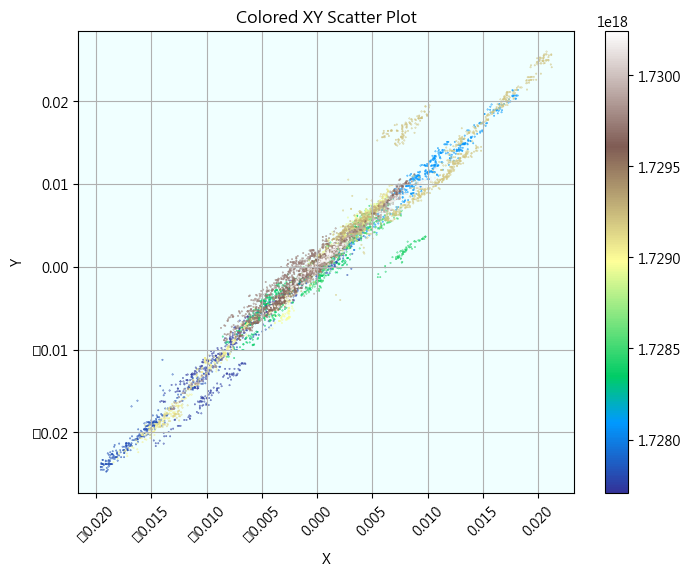
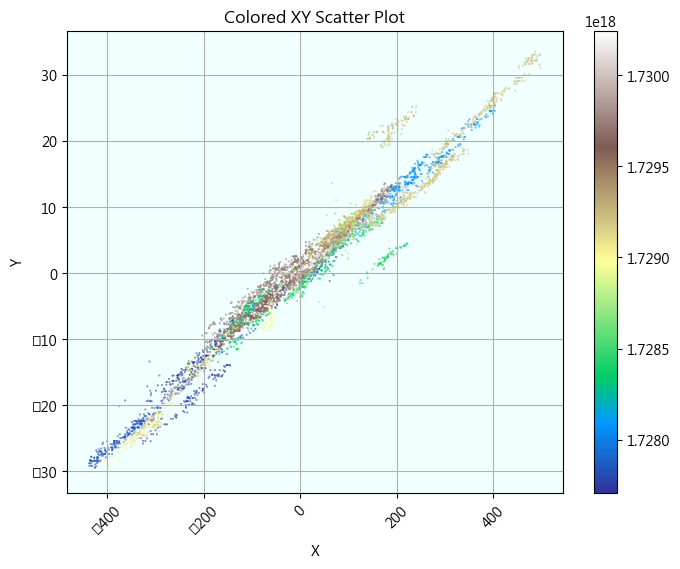
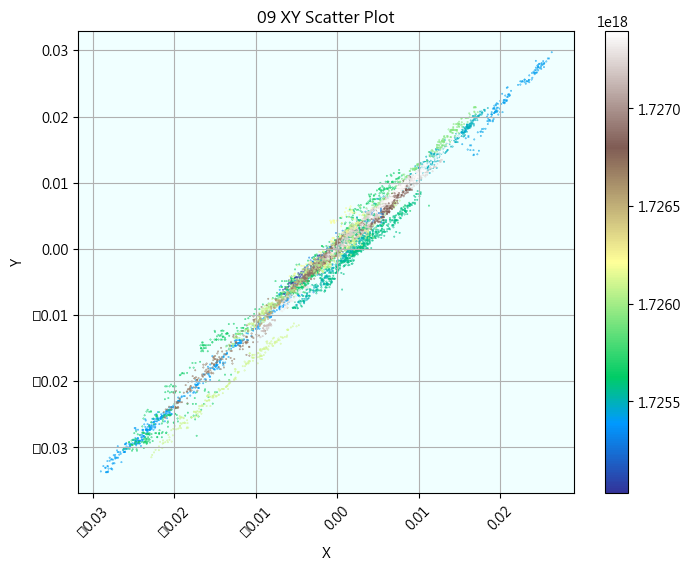

In [81]:
df_皮爾森 = TXF_ZEF自減價格關係_df.dropna()

d:\source\Anaconda\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


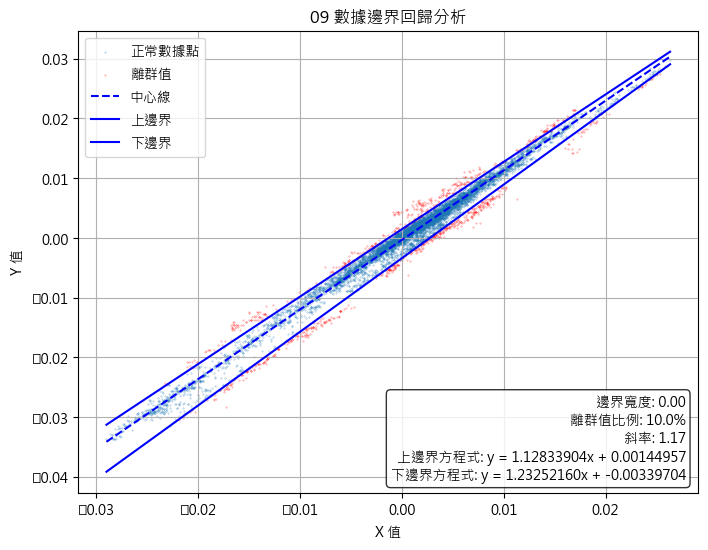

邊界寬度: 0.00
離群值比例: 10.0%
中心線斜率: 1.17
上邊界斜率: 1.13
下邊界斜率: 1.23
上邊界方程式: y = 1.12833904x + 0.00144957
下邊界方程式: y = 1.23252160x + -0.00339704


In [83]:
class BoundaryRegressor:
    def __init__(self, lower_quantile, upper_quantile):
        """
        初始化邊界回歸分析器

        參數:
        lower_quantile: 下邊界分位數 (0-1之間)
        upper_quantile: 上邊界分位數 (0-1之間)
        """
        self.lower_quantile = lower_quantile
        self.upper_quantile = upper_quantile

    def fit(self, x, y):
        """
        擬合數據邊界
        """
        # 將數據整理為DataFrame格式
        df = pd.DataFrame({"x": x, "y": y})

        # 計算中心回歸線
        X = x.values.reshape(-1, 1)
        self.center_reg = LinearRegression()
        self.center_reg.fit(X, y)

        # 使用分位數回歸計算上下邊界
        model = QuantReg(y, sm.add_constant(x))
        self.lower_reg = model.fit(q=self.lower_quantile)
        self.upper_reg = model.fit(q=self.upper_quantile)

        # 計算邊界線間距
        self.boundary_width = (
            self.upper_reg.params[1] * np.mean(x) + self.upper_reg.params[0]
        ) - (self.lower_reg.params[1] * np.mean(x) + self.lower_reg.params[0])

        # 計算離邊界的距離
        y_upper = self.upper_reg.params[0] + self.upper_reg.params[1] * x
        y_lower = self.lower_reg.params[0] + self.lower_reg.params[1] * x

        # 計算點到邊界的距離
        distances_upper = y_upper - y
        distances_lower = y - y_lower

        # 標記離群值
        self.outliers = (distances_upper < 0) | (distances_lower < 0)

        return self

    def plot(self, x, y, figsize=(8, 6)):
        """
        繪製結果
        """
        plt.figure(figsize=figsize)

        # 繪製散點
        plt.scatter(
            x[~self.outliers], y[~self.outliers], alpha=0.5, label="正常數據點", s=0.1
        )
        plt.scatter(
            x[self.outliers],
            y[self.outliers],
            color="red",
            alpha=0.5,
            label="離群值",
            s=0.1,
        )

        # 生成預測線的x值
        x_line = np.array([x.min(), x.max()])

        # 繪製中心線
        y_center = self.center_reg.predict(x_line.reshape(-1, 1))
        plt.plot(x_line, y_center, "b--", label="中心線")

        # 繪製上下邊界線
        y_upper = self.upper_reg.params[0] + self.upper_reg.params[1] * x_line
        y_lower = self.lower_reg.params[0] + self.lower_reg.params[1] * x_line

        plt.plot(x_line, y_upper, "b-", label="上邊界")
        plt.plot(x_line, y_lower, "b-", label="下邊界")
        # 計算上邊界線的斜率和截距
        slope_upper = (y_upper[1] - y_upper[0]) / (x_line[1] - x_line[0])
        self.intercept_upper = y_upper[0] - slope_upper * x_line[0]

        # 計算下邊界線的斜率和截距
        slope_lower = (y_lower[1] - y_lower[0]) / (x_line[1] - x_line[0])
        self.intercept_lower = y_lower[0] - slope_lower * x_line[0]

        # 添加註解
        info_text = (
            f"邊界寬度: {self.boundary_width:.2f}\n"
            f"離群值比例: {self.outliers.mean():.1%}\n"
            f"斜率: {self.center_reg.coef_[0]:.2f}\n"
            f"上邊界方程式: y = {self.upper_reg.params[1]:.8f}x + {self.intercept_upper:.8f}\n"
            f"下邊界方程式: y = {self.lower_reg.params[1]:.8f}x + {self.intercept_lower:.8f}"
        )
        plt.text(
            0.98,  # 改為0.98,靠右側
            0.02,  # 改為0.02,靠下方
            info_text,
            transform=plt.gca().transAxes,
            horizontalalignment="right",  # 改為靠右對齊
            verticalalignment="bottom",  # 改為靠下對齊
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
        )

        plt.xlabel("X 值")
        plt.ylabel("Y 值")
        plt.title("09 數據邊界回歸分析")
        plt.legend()
        plt.grid(True)
        plt.show()

    def get_statistics(self):
        """
        獲取統計信息
        """
        return {
            "boundary_width": self.boundary_width,
            "outlier_ratio": self.outliers.mean(),
            "center_slope": self.center_reg.coef_[0],
            "upper_slope": self.upper_reg.params[1],
            "lower_slope": self.lower_reg.params[1],
            "outlier_indices": np.where(self.outliers)[0],
            "upper_intercept": self.intercept_upper,
            "lower_intercept": self.intercept_lower,
            "upper_equation": f"y = {self.upper_reg.params[1]:.8f}x + {self.intercept_upper:.8f}",
            "lower_equation": f"y = {self.lower_reg.params[1]:.8f}x + { self.intercept_lower:.8f}",
        }


plt.style.use("default")
# 創建分析器實例
regressor = BoundaryRegressor(lower_quantile=0.05, upper_quantile=0.95)

# 擬合數據
x = df_皮爾森["txf_percent"]
y = df_皮爾森["zef_percent"]
regressor.fit(x, y)

# 繪製結果
regressor.plot(x, y)

# 獲取統計信息
stats = regressor.get_statistics()
print(f"邊界寬度: {stats['boundary_width']:.2f}")
print(f"離群值比例: {stats['outlier_ratio']:.1%}")
print(f"中心線斜率: {stats['center_slope']:.2f}")
print(f"上邊界斜率: {stats['upper_slope']:.2f}")
print(f"下邊界斜率: {stats['lower_slope']:.2f}")
print(f"上邊界方程式: {stats['upper_equation']}")
print(f"下邊界方程式: {stats['lower_equation']}")

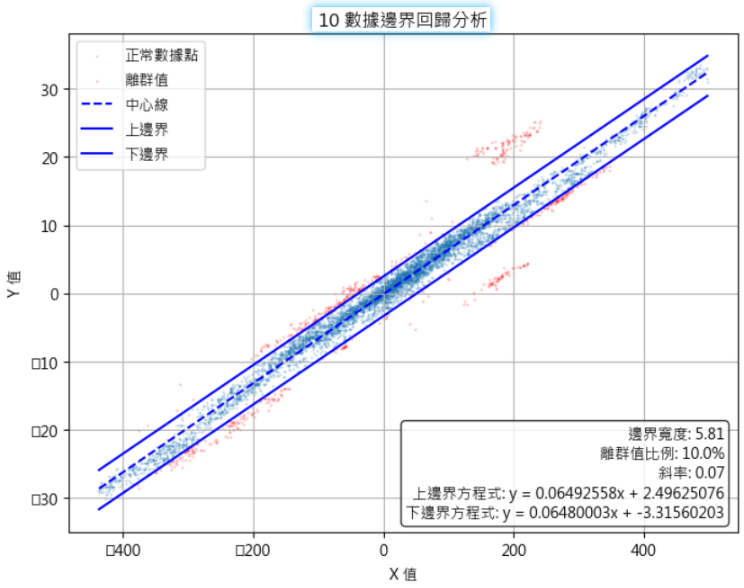
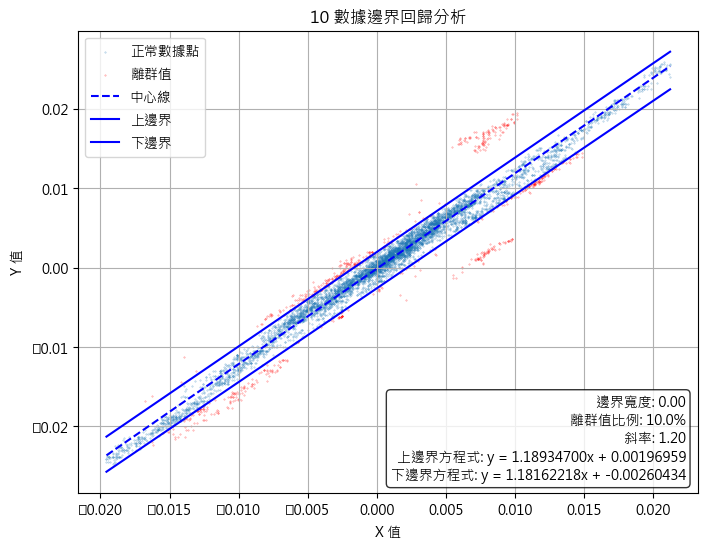
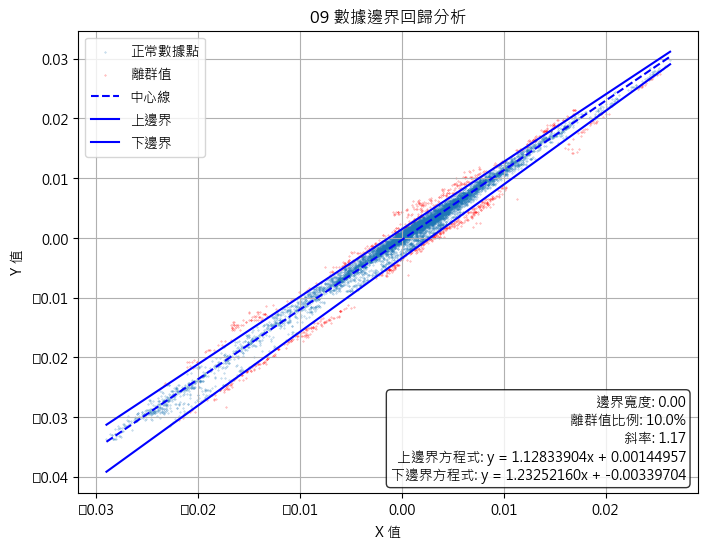
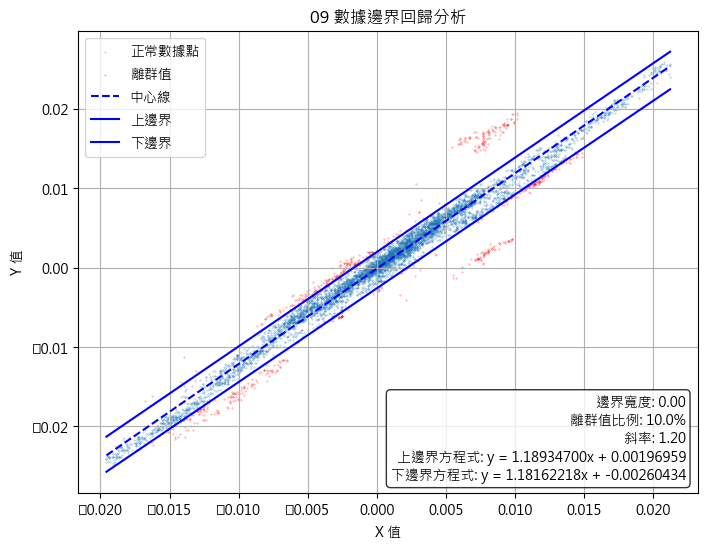
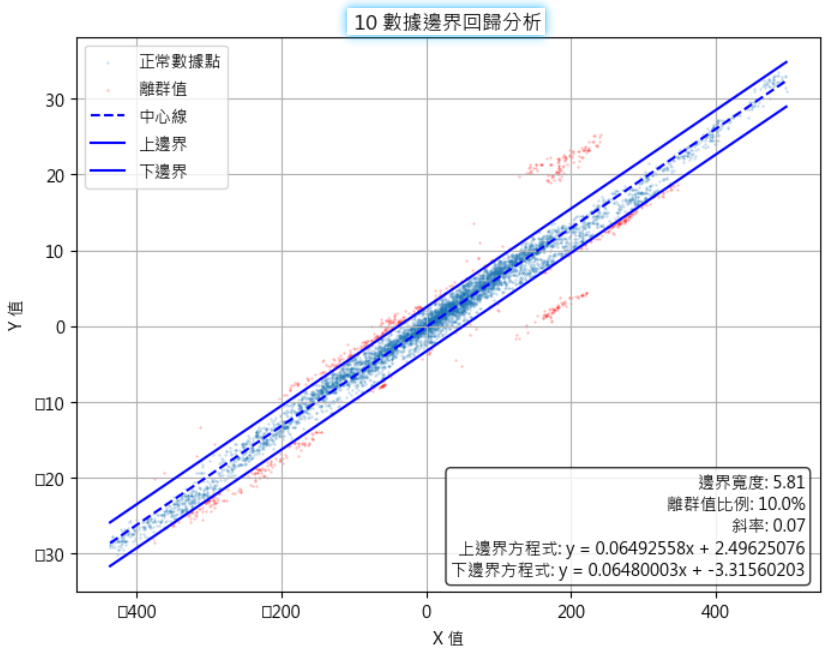
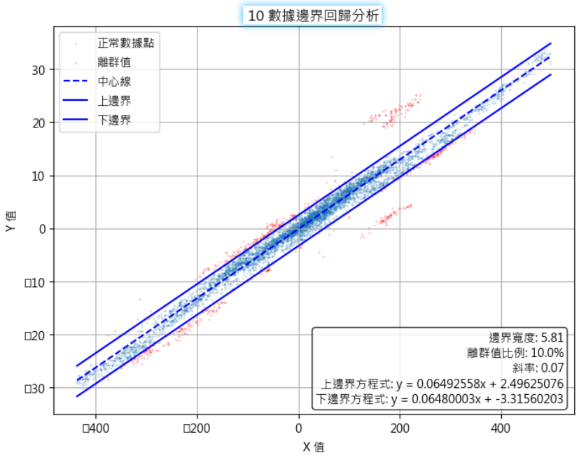
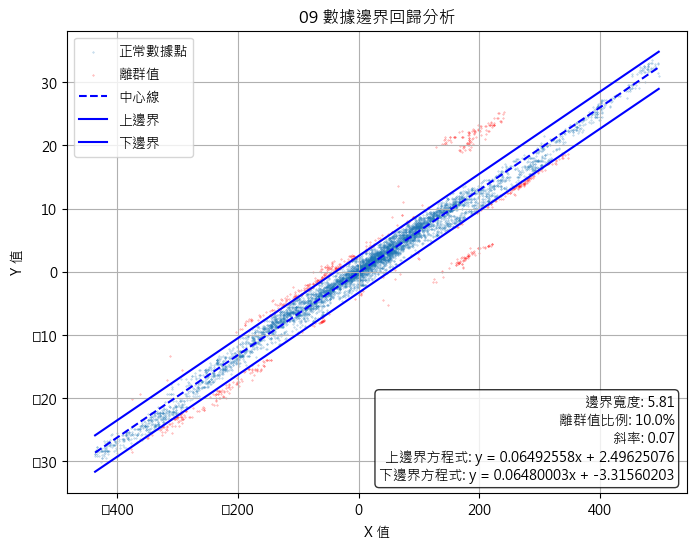

In [67]:
TXF_ZEF自減價格關係_df.to_csv("datas/觀察超實在TXF_ZEF自減價格關係.csv")

##### 開始回測

In [86]:
for i in ["08", "09", "10", "11"]:
    exec(f"TXF{i}_df = pd.read_parquet(f'datas/SJ_下載{i}月的TXF逐筆成交明細.pqt')")
    exec(f"ZEF{i}_df = pd.read_parquet(f'datas/SJ_下載{i}月的ZEF逐筆成交明細.pqt')")
    exec(f"TXF{i}_df.ts = pd.to_datetime(TXF{i}_df.ts)")
    exec(f"ZEF{i}_df.ts = pd.to_datetime(ZEF{i}_df.ts)")
    exec(f"TXF{i}_df = TXF{i}_df.set_index('ts')")
    exec(f"ZEF{i}_df = ZEF{i}_df.set_index('ts')")
    exec(f"TXF{i}_df_sec = TXF{i}_df.resample('1s').last().dropna().reset_index()")
    exec(f"ZEF{i}_df_sec = ZEF{i}_df.resample('1s').last().dropna().reset_index()")
    exec(
        f'TXF{i}_df_sec_close = TXF{i}_df_sec[["ts", "close", "bid_price", "ask_price"]]'
    )
    exec(
        f'ZEF{i}_df_sec_close = ZEF{i}_df_sec[["ts", "close", "bid_price", "ask_price"]]'
    )


# TXF10_df = pd.read_parquet("datas/SJ_下載10月的TXF逐筆成交明細.pqt")
# ZEF10_df = pd.read_parquet("datas/SJ_下載10月的ZEF逐筆成交明細.pqt")

In [115]:
TXF_df_sec = TXF10_df_sec_close.copy()
ZEF_df_sec = ZEF10_df_sec_close.copy()

# 轉換 ts 欄位成 datetime 格式
TXF_df_sec["ts"] = pd.to_datetime(TXF_df_sec["ts"])
ZEF_df_sec["ts"] = pd.to_datetime(ZEF_df_sec["ts"])

# 使用 merge_asof 進行時間戳配對
merged_df = pd.merge_asof(
    ZEF_df_sec[["ts", "close"]],
    TXF_df_sec[["ts", "close"]],
    on="ts",
    suffixes=("_zef", "_txf"),
    direction="backward",
)

# 最後只保留需要的欄位
ZEF_TXF_sec = merged_df[["ts", "close_txf", "close_zef"]]
ZEF_TXF_sec.index = ZEF_TXF_sec["ts"]

# 排除15:00以前或05:00以後的資料
ZEF_TXF_sec = ZEF_TXF_sec[
    ((ZEF_TXF_sec.index.time >= pd.to_datetime("15:00:00").time())
    & (ZEF_TXF_sec.index.time <= pd.to_datetime("23:59:59").time()))
    | ((ZEF_TXF_sec.index.time >= pd.to_datetime("00:00:00").time())
    & (ZEF_TXF_sec.index.time <= pd.to_datetime("04:59:59").time()))
]
ZEF_TXF_sec

,ts,close_txf,close_zef
ts,,,
2024-09-30 15:01:13,2024-09-30 15:01:13,22351.0,1188.60
2024-09-30 15:01:14,2024-09-30 15:01:14,22351.0,1186.50
2024-09-30 15:01:30,2024-09-30 15:01:30,22360.0,1189.45
2024-09-30 15:01:33,2024-09-30 15:01:33,22361.0,1189.45
2024-09-30 15:01:35,2024-09-30 15:01:35,22362.0,1186.65
...,...,...,...
2024-10-30 04:41:38,2024-10-30 04:41:38,23054.0,1261.70
2024-10-30 04:49:06,2024-10-30 04:49:06,23043.0,1261.10
2024-10-30 04:54:23,2024-10-30 04:54:23,23056.0,1261.40


In [116]:
df = ZEF_TXF_sec.copy()
# 假設 `df` 是您的資料
# 建立 datetime index
df["ts"] = pd.to_datetime(df["ts"])  # 確保 datetime 欄位是 datetime 格式
df.set_index("ts", inplace=True)

# 每天的 15:00 到 15:10 的最後價格作為基準
# 首先將資料根據日期分組
df["date"] = df.index.date  # 提取日期
base_prices = (
    df.between_time("15:00", "15:10").groupby("date").last()
)  # 每天 15:10 的最後價格

# base_prices 包含每天的基準價格
df["txf_base"] = df["date"].map(base_prices["close_txf"])  # 將基準價格映射到 df 中
df["zef_base"] = df["date"].map(base_prices["close_zef"])

# 計算漲跌百分比
df["txf_percent"] = (df["close_txf"] - df["txf_base"]) / df["txf_base"]
df["zef_percent"] = (df["close_zef"] - df["zef_base"]) / df["zef_base"]

# 清理不再需要的欄位
# df.drop(columns=["txf_base", "zef_base", "date"], inplace=True)

# print(df[["close_txf", "txf_percent", "close_zef", "zef_percent"]])
df

,close_txf,close_zef,date,txf_base,zef_base,txf_percent,zef_percent
ts,,,,,,,
2024-09-30 15:01:13,22351.0,1188.60,2024-09-30,22410.0,1191.5,-0.002633,-0.002434
2024-09-30 15:01:14,22351.0,1186.50,2024-09-30,22410.0,1191.5,-0.002633,-0.004196
2024-09-30 15:01:30,22360.0,1189.45,2024-09-30,22410.0,1191.5,-0.002231,-0.001721
2024-09-30 15:01:33,22361.0,1189.45,2024-09-30,22410.0,1191.5,-0.002187,-0.001721
2024-09-30 15:01:35,22362.0,1186.65,2024-09-30,22410.0,1191.5,-0.002142,-0.004070
...,...,...,...,...,...,...,...
2024-10-30 04:41:38,23054.0,1261.70,2024-10-30,NaN,NaN,NaN,NaN
2024-10-30 04:49:06,23043.0,1261.10,2024-10-30,NaN,NaN,NaN,NaN
2024-10-30 04:54:23,23056.0,1261.40,2024-10-30,NaN,NaN,NaN,NaN


In [117]:
def generate_signal(df,上A,上B,下A,下B):
    """
    根據給定的條件生成信號欄位：
    - 當 percent_y > 1.2237 * percent_x + 0.00324 時，signal = 1
    - 當 percent_y > 1.119066 * percent_x - 0.00340 時，signal = -1
    - 其餘情況，signal = 0

    Parameters:
    df (pandas.DataFrame): 包含 percent_x 和 percent_y 欄位的 DataFrame

    Returns:
    pandas.DataFrame: 添加 signal 欄位後的 DataFrame
    """
    # 創建一個新的 DataFrame 副本
    result_df = df.copy()

    # 初始化 signal 欄位為 0
    result_df["signal"] = 0

    # 條件 1: 當 percent_y > 1.2237 * percent_x + 0.00324 時，signal = 1
    condition1 = df["zef_percent"] > (上A * df["txf_percent"] + 上B)
    result_df.loc[condition1, "signal"] = 1

    # 條件 2: 當 percent_y > 1.119066 * percent_x - 0.00340 時，signal = -1
    condition2 = df["zef_percent"] < (下A * df["txf_percent"] - 下B)
    result_df.loc[condition2, "signal"] = -1
    return result_df


# 使用範例：

交易訊號10_df = generate_signal(
    df, 上A=1.189347, 上B=0.00196959, 下A=1.18162218, 下B=0.00260434
)  # 20% 有比5%還要少了
交易訊號10_df

,close_txf,close_zef,date,txf_base,zef_base,txf_percent,zef_percent,signal
ts,,,,,,,,
2024-09-30 15:01:13,22351.0,1188.60,2024-09-30,22410.0,1191.5,-0.002633,-0.002434,0
2024-09-30 15:01:14,22351.0,1186.50,2024-09-30,22410.0,1191.5,-0.002633,-0.004196,0
2024-09-30 15:01:30,22360.0,1189.45,2024-09-30,22410.0,1191.5,-0.002231,-0.001721,0
2024-09-30 15:01:33,22361.0,1189.45,2024-09-30,22410.0,1191.5,-0.002187,-0.001721,0
2024-09-30 15:01:35,22362.0,1186.65,2024-09-30,22410.0,1191.5,-0.002142,-0.004070,0
...,...,...,...,...,...,...,...,...
2024-10-30 04:41:38,23054.0,1261.70,2024-10-30,NaN,NaN,NaN,NaN,0
2024-10-30 04:49:06,23043.0,1261.10,2024-10-30,NaN,NaN,NaN,NaN,0
2024-10-30 04:54:23,23056.0,1261.40,2024-10-30,NaN,NaN,NaN,NaN,0


In [120]:
@jit(nopython=True)
def compute_positions_and_pnl(signals, hours, prices, n_rows):
    """
    使用 numba 加速核心計算邏輯，新增 floating_pnl 欄位並修改避開入場的條件
    """
    positions = np.zeros(n_rows)
    pnl = np.zeros(n_rows)
    floating_pnl = np.zeros(n_rows)
    entry_prices = np.zeros(n_rows)

    current_position = 0
    entry_price = 0.0
    cumulative_pnl = 0.0
    last_loss_row = -301  # 初始化為超過 300 個 row 之前的值，以便一開始可以正常入場

    for i in range(n_rows):
        price = prices[i]

        # 如果有持倉，計算浮動盈虧
        if current_position != 0:
            unrealized_pnl = (price - entry_price) * current_position
            floating_pnl[i] = unrealized_pnl

            # 檢查是否需要平倉 (合併條件檢查)
            if (
                hours[i] == 4
                or hours[i] == 5
                or unrealized_pnl > 1
                or unrealized_pnl < -1
            ):
                cumulative_pnl += unrealized_pnl
                if unrealized_pnl < 0:
                    last_loss_row = i  # 記錄虧損發生的 row
                current_position = 0
                entry_price = 0
                floating_pnl[i] = 0  # 平倉後浮動盈虧歸零

        # 如果沒有持倉且可以開倉
        elif i > last_loss_row + 300:  # 避開上次虧損發生後 300 個 row
            signal = signals[i]
            if signal == -1:
                current_position = 1
                entry_price = price
            elif signal == 1:
                current_position = -1
                entry_price = price

        # 儲存目前的持倉資訊
        positions[i] = current_position
        entry_prices[i] = entry_price
        pnl[i] = cumulative_pnl

    return positions, pnl, entry_prices, floating_pnl


def ultra_fast_backtest(df):
    """
    使用 numba 和向量化操作的超快回測函數
    """
    # 創建副本避免修改原始數據
    result_df = df.copy()

    # 將時間轉換為小時 (向量化操作)
    hours = pd.to_datetime(result_df.index).hour.values

    # 準備 numba 需要的數組
    signals = result_df["signal"].values
    prices = result_df["close_zef"].values
    n_rows = len(result_df)

    # 使用 numba 加速的核心計算
    positions, pnl, entry_prices, floating_pnl = compute_positions_and_pnl(
        signals, hours, prices, n_rows
    )

    # 將結果寫回 DataFrame
    result_df["position"] = positions
    result_df["pnl"] = pnl
    result_df["entry_price"] = entry_prices
    result_df["floating_pnl"] = floating_pnl
    result_df["hours"] = hours

    return result_df


回測結果_df = ultra_fast_backtest(交易訊號10_df)
回測結果_df.tail()

,close_txf,close_zef,date,txf_base,zef_base,txf_percent,zef_percent,signal,position,pnl,entry_price,floating_pnl,hours
ts,,,,,,,,,,,,,
2024-10-30 04:41:38,23054.0,1261.70,2024-10-30,NaN,NaN,NaN,NaN,0,0.0,45.05,0.0,0.0,4
2024-10-30 04:49:06,23043.0,1261.10,2024-10-30,NaN,NaN,NaN,NaN,0,0.0,45.05,0.0,0.0,4
2024-10-30 04:54:23,23056.0,1261.40,2024-10-30,NaN,NaN,NaN,NaN,0,0.0,45.05,0.0,0.0,4
2024-10-30 04:59:00,23055.0,1261.40,2024-10-30,NaN,NaN,NaN,NaN,0,0.0,45.05,0.0,0.0,4
2024-10-30 04:59:58,23055.0,1262.35,2024-10-30,NaN,NaN,NaN,NaN,0,0.0,45.05,0.0,0.0,4


In [122]:
回測結果_df.to_csv("datas/觀察回測結果10_df.csv")

C:\Users\tseng\AppData\Local\Temp\ipykernel_6680\3609884753.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


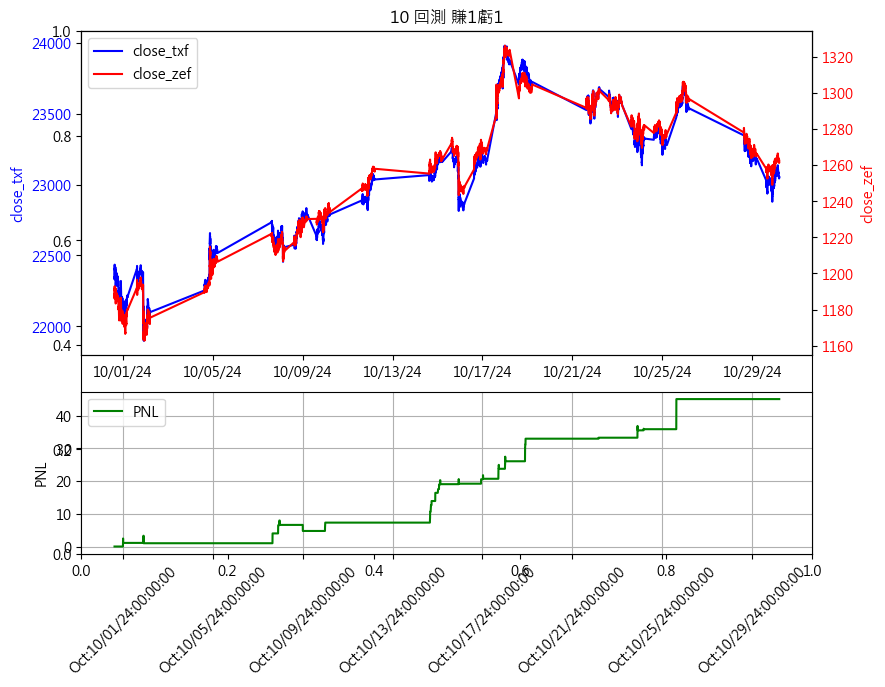

In [121]:
%matplotlib inline
df = 回測結果_df.copy()
df['ts']=df.index
# 假設您的數據已經在 df DataFrame 中
# 設置圖表風格
plt.style.use("default")

# 創建圖表和軸域
fig = plt.figure(figsize=(8, 6))
plt.title("10 回測 賺1虧1")

# 創建上下兩個子圖，height_ratios=[2, 1] 表示上圖高度是下圖的2倍
gs = fig.add_gridspec(2, 1, height_ratios=[2, 1], hspace=0.15)
ax1 = fig.add_subplot(gs[0])
ax2 = ax1.twinx()  # 創建雙Y軸
ax3 = fig.add_subplot(gs[1])

# 繪製 close_x 在左Y軸
line1 = ax1.plot(df["ts"], df["close_txf"], color="blue", label="close_txf")
ax1.set_ylabel("close_txf", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# 繪製 close_y 在右Y軸
line2 = ax2.plot(df["ts"], df["close_zef"], color="red", label="close_zef")
ax2.set_ylabel("close_zef", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# 添加圖例
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="upper left")

# 繪製下方的 PNL 圖
ax3.plot(df["ts"], df["pnl"], color="green", label="PNL")
ax3.set_ylabel("PNL")
ax3.legend(loc="upper left")

# 設置 x 軸格式
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%D"))

for ax in [ax3]:
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b:%D:%H:%M:%S"))
    plt.xticks(rotation=45)
    ax.grid(True)

# 只在底部子圖顯示 x 軸標籤
# ax1.set_xticklabels([])

# 調整布局
plt.tight_layout()
# 顯示圖表
plt.show()